# SISO 1D Spiking Radar System (OOP Demo)

This notebook runs the modular spiking radar pipeline and displays each stage.

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path('..') / 'src'))

from config import PhysicsConfig, SpikingRadarConfig, ObjectsConfig
from transmitter import SpikingRadarTx, SpikingRadarTransmitter
from environment import SpikingRadarChannel_1D
from receiver import SpikingRadarRx, SpikingRadarReceiver_1D
from models.spiking_radar import SpikingRadarCorrelator
from output import SpikingRadarResult_1D



In [32]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.1,
    spike_prob_per_ms=0.1,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.1,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
)
objects = ObjectsConfig(object_location_1D = 4.0)

transmitter = SpikingRadarTransmitter(model_config)
environment = SpikingRadarChannel_1D(model_config, physics_config, objects)
receiver = SpikingRadarReceiver_1D(model_config)
processing_model = SpikingRadarCorrelator(model_config, physics_config)





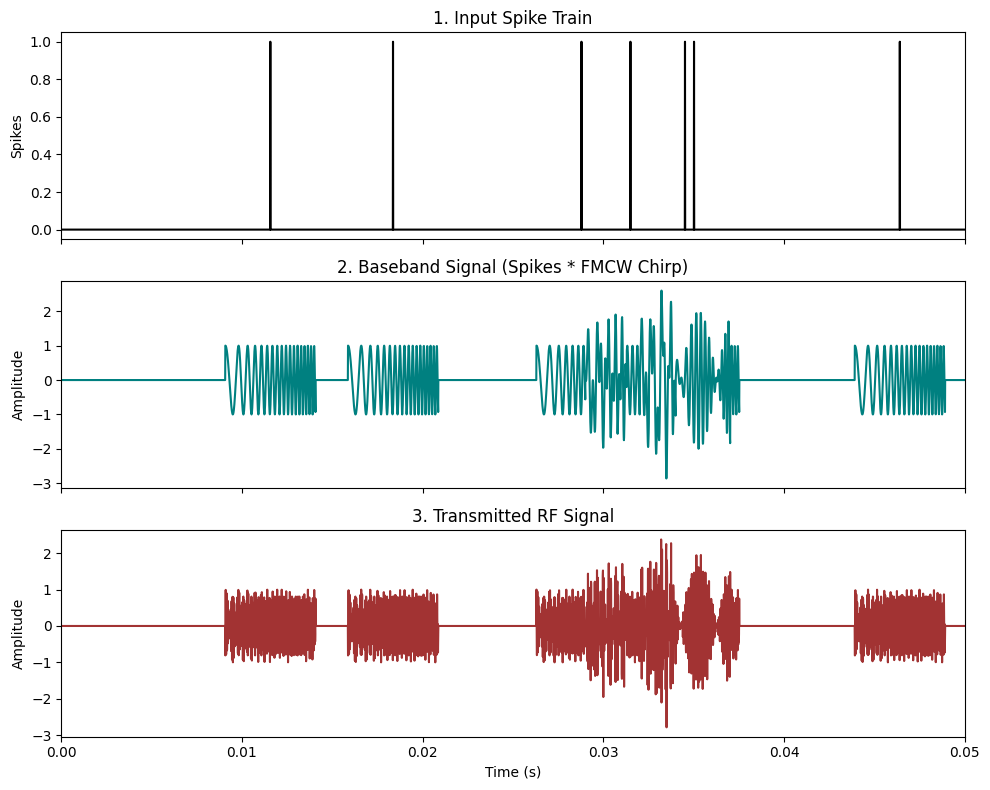

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: title={'center': '1. Input Spike Train'}, ylabel='Spikes'>,
        <Axes: title={'center': '2. Baseband Signal (Spikes * FMCW Chirp)'}, ylabel='Amplitude'>,
        <Axes: title={'center': '3. Transmitted RF Signal'}, xlabel='Time (s)', ylabel='Amplitude'>],
       dtype=object))

In [33]:
# transmitter

tx = transmitter.build()
transmitter.plot(tx)


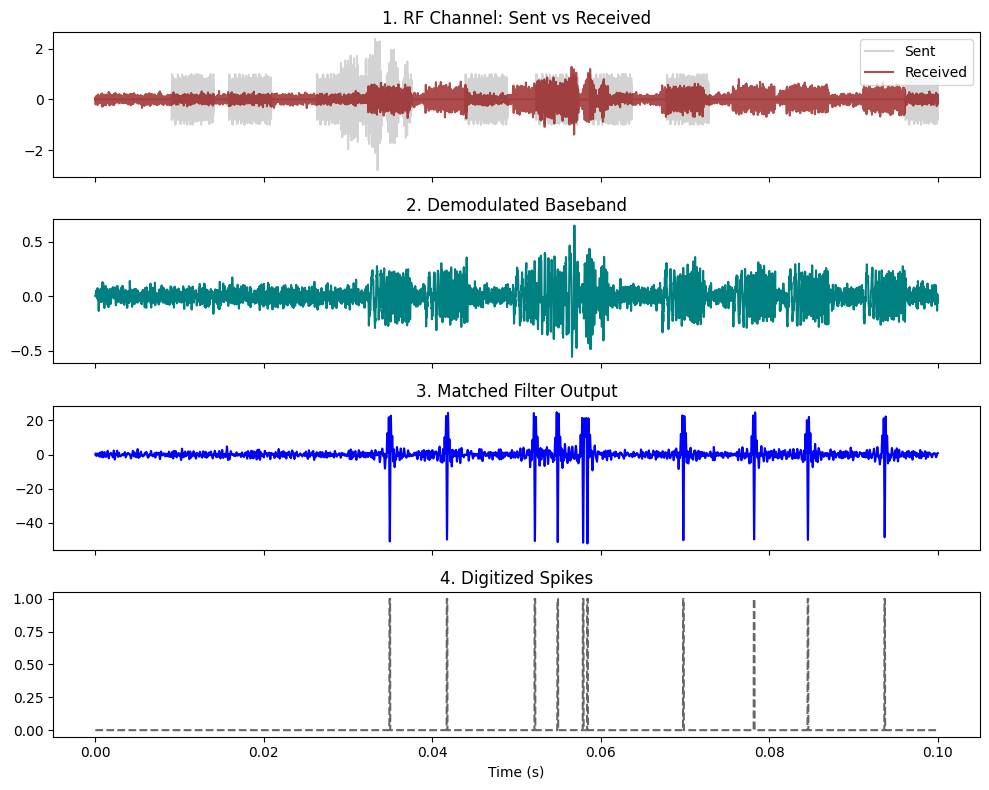

(<Figure size 1000x800 with 4 Axes>,
 array([<Axes: title={'center': '1. RF Channel: Sent vs Received'}>,
        <Axes: title={'center': '2. Demodulated Baseband'}>,
        <Axes: title={'center': '3. Matched Filter Output'}>,
        <Axes: title={'center': '4. Digitized Spikes'}, xlabel='Time (s)'>],
       dtype=object))

In [34]:
# Environment and receiver

rx_signal = environment.propagate(tx.tx_signal)

demod_raw = receiver.demodulate(rx_signal, tx.time_s)
rx_baseband = receiver.lowpass(demod_raw)
recovered_signal = receiver.matched_filter(rx_baseband, tx.chirp_template)
recovered_spikes = receiver.recover_spikes(recovered_signal)

rx = SpikingRadarRx(
    rx_signal=rx_signal,
    rx_baseband=rx_baseband,
    recovered_signal=recovered_signal,
    recovered_spikes=recovered_spikes,
)
receiver.plot(tx.time_s, tx.tx_signal, rx)

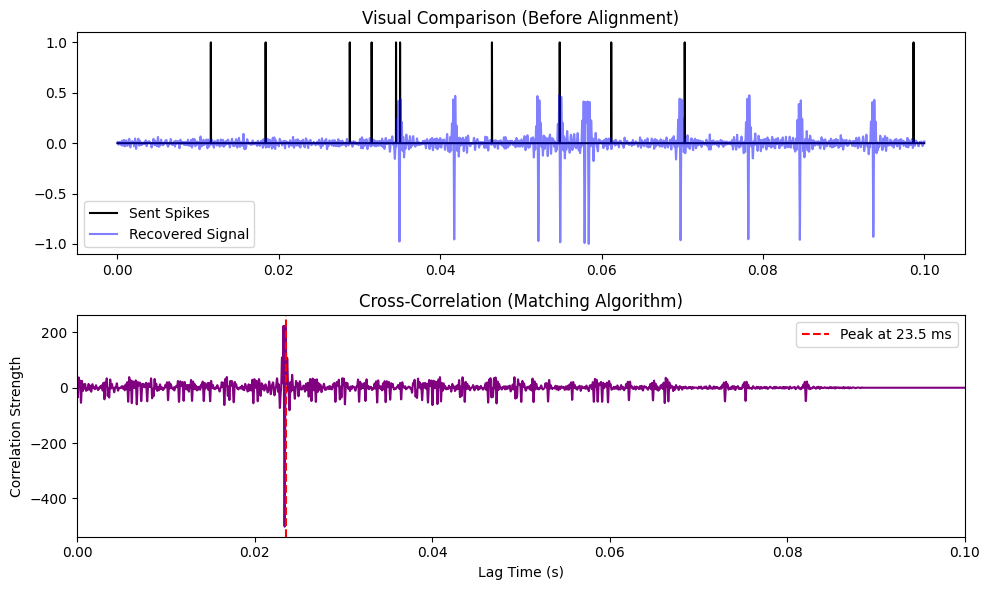

(<Figure size 1000x600 with 2 Axes>,
 array([<Axes: title={'center': 'Visual Comparison (Before Alignment)'}>,
        <Axes: title={'center': 'Cross-Correlation (Matching Algorithm)'}, xlabel='Lag Time (s)', ylabel='Correlation Strength'>],
       dtype=object))

In [35]:
# Processing unit

correlation, lags = processing_model.correlate(recovered_signal, tx.spikes)
distance_est, delay_s = processing_model.estimate_distance(correlation, lags)

processing_model.plot(
        tx.time_s,
        tx.spikes,
        recovered_signal,
        correlation,
        lags,
        delay_s,
    )




In [36]:
# Output

results = SpikingRadarResult_1D(
    distance_m=distance_est,
    delay_s=delay_s,
    correlation=correlation,
    lag_s=lags / model_config.fs_hz,
    tx=tx,
    rx=rx,
    objects=objects
)

results.print_results()

--- RESULTS ---
Actual Wall Distance:    4.0 m
Calculated Distance:     4.03025 m
Error:                   0.030249999999999666 m
